# 非极大值抑制算法(NMS)及python实现

    https://blog.csdn.net/Blateyang/article/details/79113030
    
    已加入 mylibs.py_nms.py
    
    在目标检测中，常会利用非极大值抑制算法(NMS)对生成的大量候选框进行后处理，去除冗余的候选框，得到最具代表性的结果，以加快目标检测的效率。即如下图所示，消除多余的候选框，找到最佳的bbox。
    
<img src='images/nms.png' >

## NMS算法过程

根据候选框的类别分类概率做排序：A&lt;B&lt;C&lt;D&lt;E&lt;F

A<B<C<D<E<F

    先标记最大概率矩形框F是我们要保留下来的；
    从最大概率矩形框F开始，分别判断A~E与F的重叠度IOU（两框的交并比）是否大于某个设定的阈值，假设B、D与F的重叠度超过阈值，那么就扔掉B、D；
    从剩下的矩形框A、C、E中，选择概率最大的E，标记为要保留下来的，然后判读E与A、C的重叠度，扔掉重叠度超过设定阈值的矩形框

就这样一直重复下去，直到剩下的矩形框没有了，标记完所有要保留下来的矩形框

[0, 2]
[[ 50.   60.  200.  300.    1. ]
 [100.  120.  260.  360.    0.8]]


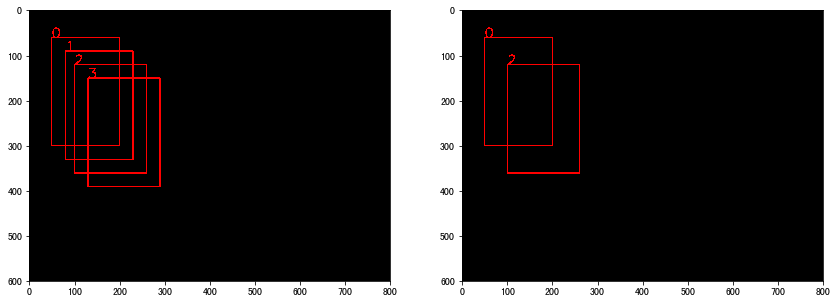

In [37]:
# python3 
import numpy as np 
def py_nms(dets, thresh): 
    '''Pure Python NMS baseline.
    dets   => [[x1,x1,x2,y2,score],......]
    thresh => 0-1 ,float
    
    return [id1,....],保留的矩形框序号
    '''
    #x1、y1、x2、y2、以及score赋值 
    x1 = dets[:, 0] 
    y1 = dets[:, 1] 
    x2 = dets[:, 2] 
    y2 = dets[:, 3] 
    scores = dets[:, 4] 
    
    #每一个候选框的面积 
    areas = (x2 - x1 + 1) * (y2 - y1 + 1) 
    #order是按照score降序排序的 
    order = scores.argsort()[::-1] 
    keep = [] 
    while order.size > 0: 
        i = order[0] 
        keep.append(i) 
        #计算当前概率最大矩形框与其他矩形框的相交框的坐标，会用到numpy的broadcast机制，得到的是向量 
        xx1 = np.maximum(x1[i], x1[order[1:]]) 
        yy1 = np.maximum(y1[i], y1[order[1:]]) 
        xx2 = np.minimum(x2[i], x2[order[1:]]) 
        yy2 = np.minimum(y2[i], y2[order[1:]]) 
        #计算相交框的面积,注意矩形框不相交时w或h算出来会是负数，用0代替 
        w = np.maximum(0.0, xx2 - xx1 + 1) 
        h = np.maximum(0.0, yy2 - yy1 + 1) 
        inter = w * h 
        #计算重叠度IOU：重叠面积/（面积1+面积2-重叠面积） 
        ovr = inter / (areas[i] + areas[order[1:]] - inter) 
        #找到重叠度不高于阈值的矩形框索引 
        inds = np.where(ovr <= thresh)[0] 
        #将order序列更新，由于前面得到的矩形框索引要比矩形框在原order序列中的索引小1，所以要把这个1加回来 
        order = order[inds + 1] 
    return keep 

#========测试========
# test 
#if __name__ == "__main__": 
#构造矩形框数据
dets = np.array(
        [[50, 60, 200, 300, 1], 
         [80, 90, 230, 330, 0.9], 
         [100, 120, 260, 360, 0.8], 
         [130, 150, 290, 390, 0.7]]) 
texts=['0','1','2','3']

#阈值
thresh = 0.5 
#NMS检测
keep_dets = py_nms(dets, thresh) 
#保留序号
print(keep_dets) 
#保留矩形框
print(dets[keep_dets])

#结果图形化输出
import numpy as np
import cv2
import matplotlib.pyplot as plt
from mylibs.views.draw_boxs import draw_boxs
img=np.zeros((600,800,3),dtype=np.uint8)
img1=img.copy()
img2=img.copy()
img1=draw_boxs(img1,dets[:,0:4].astype(np.int),thickness=2,texts=['0','1','2','3'])
img2=draw_boxs(img2,dets[keep_dets,0:4].astype(np.int),thickness=2,texts=[texts[i] for i in keep_dets])
plt.figure(figsize=(1024/72.,768/72.))
plt.subplot(1,2,1)
plt.imshow(img1)  
plt.subplot(1,2,2)
plt.imshow(img2)